# Retrieval Augmented Generation

## What is a RAG

Retrieval-Augmented Generation (RAG) is a machine learning framework that combines the benefits of pre-trained language models with external knowledge retrieval. It's designed to enhance the capabilities of large language models by enabling them to access and incorporate information from external data sources.


Use Cases: Information retrieval systems, chatbots, document summarization tools, and other knowledge-intensive tasks.​

RAG operates in a structured, three-stage manner, each stage playing a pivotal role in the generation of accurate and contextually enriched responses:

- The Retriever: This initial stage is akin to a diligent librarian. It scours through a vast corpus of text, seeking out documents or passages that resonate with the query. The retriever is the gateway to relevant knowledge, setting the stage for insightful responses.
- Post Node Processing: Think of this as the refining crucible. It takes the raw, retrieved information and polishes it, ensuring that the final response is not just relevant but also refined and of high quality.
- Response Synthesizer: The final flourish comes from this stage. It weaves together the processed information and the original query to generate a response that's coherent, contextually appropriate, and seemingly conjured from the depths of human-like understanding.

![](https://lucid.app/publicSegments/view/92bbd8e3-3eca-4949-9e6f-0d3a923fec1f/image.png)






## What are the main challenges of RAG

Data Quality and Diversity:

- Quality of Source Documents: Quality affects the output; inaccuracies in source documents can lead to errors in generated responses.​
- Document Diversity and Style Variations: Documents vary in style, structure, and format, posing a challenge for uniform processing.​


Domain-Specific Considerations:

- Domain-Specific Jargon and Context: Specialized fields often use specific jargon, requiring customization to ensure the model's effectiveness.​
- Semantic Understanding and Embeddings: Ensuring that embeddings accurately capture the semantic meaning and nuances of texts is a challenge.​

Precision and Coherence in Responses:

- Balance Between Precision and Response Quality: A trade-off exists between the precision of retrieved documents and the coherence of the generated response.
- Chunk Text and Contextual Limitations: The size of text chunks impacts performance, with larger chunks providing more context but being computationally intensive.


Relevance and Comprehensiveness:

- Handling of False Positives: Systems may retrieve irrelevant documents appearing relevant due to keyword matching, necessitating mechanisms to discern true relevance.
- Management of Open-Ended Queries and Summarization: The system must collate and synthesize information from various sources for broad queries or comprehensive summarizations without missing key details.

Coherence and Consistency in Information:
- Document Coherence and Contradictions: With a large number of documents, inconsistencies or contradictions may arise, challenging the system's ability to generate coherent and accurate responses.
- Temporal Relevance and Outdated Information: Documents may become outdated over time. The system's ability to discern and prioritize the most current and relevant information is crucial to avoid basing responses on outdated or obsolete data.

## Common techniques for each stage

### Commonly used Retrievers

- Basic Retriever: Similarity search algorithm between the query and the documents in the vector store
- BM25: BM25 algorithm is a method that ranks documents based on how often the words in your search query appear in those documents, while also considering the length of the documents
- Fusion retriever: Combine the use of two retrievers to find candidates, sort and extract the top n 

### Node Post Processor

- Similarity: This postprocessor filters nodes based on a similarity threshold. It ensures that only nodes with a similarity score above a certain threshold are considered in the final results. This is particularly useful in maintaining a high relevance standard in the retrieved information.
- Embedding Optimizer: Optimizes the retrieval process by considering sentence embeddings. This postprocessor takes into account the contextual similarity at a sentence level
- LLm Reranker: This postprocessor leverages the capabilities of a Large Language Model (LLM) to rerank the nodes. By understanding the content and context at a deeper level, the LLM reranks the nodes, ensuring that the most contextually relevant and informative nodes are prioritized.

### Response Synthetizer

- Simple summarize: Merge all text chunks into one and make a call to the LLM.
- Refine: This method involves an iterative process of response generation. It uses the context in the first node, along with the query, to generate an initial answer
- Tree summarize: Build a tree index over the candidate nodes, starting with a summary prompt seeded with the query

In [ ]:
#import locale
#def getpreferredencoding(do_setlocale = True):
#    return "UTF-8"
#locale.getpreferredencoding = getpreferredencoding

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [ ]:
#!pip install peft
#!pip install bitsandbytes
#!pip install accelerate
#!pip install llama_index
#!pip install pyvis
#!pip install rank_bm25
#!pip install langdetect

# Prepare data and LLm
## Load LLm model

This section details the process of integrating an LLM (Large Language Model) with the Llama Index, focusing on preparing and configuring the Mistral model for use. The Llama Index serves as an advanced backend, designed for complex search and retrieval operations. The primary aim is to set up the Mistral model, a variant of LLM optimized for generating high-quality text based on given instructions and context.

**Environment Setup**

First, we import the necessary libraries and configure the computing environment. The `transformers` library is used for accessing models and utilities for natural language processing. The `PeftModel` from `peft` aids in optimizing model parallelism and execution time, crucial for handling large models like Mistral.

In [ ]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import torch

We set the default device to GPU if available, to leverage faster computation capabilities essential for handling computationally intensive tasks of large language models.

In [ ]:
torch.set_default_device('cuda')

The `BitsAndBytesConfig` is configured to minimize the model's memory usage. By loading the model in a 4-bit precision format, applying double quantization, and specifying a computation data type, we optimize the model's performance efficiently.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


We load the `Mistral-7B-Instruct-v0.2` model using the `AutoModelForCausalLM` class, designed for causal language modeling tasks. The model predicts the next token in a sequence, making it well-suited for generating coherent and contextually relevant text. The `BitsAndBytesConfig` settings are applied to ensure an efficient use of resources.

In [ ]:
model_base = AutoModelForCausalLM.from_pretrained(
     "mistralai/Mistral-7B-Instruct-v0.2",
    quantization_config=bnb_config,
    device_map={"": 0})


The tokenizer is responsible for converting text input into a format that the model can understand, ensuring that the input text is appropriately preprocessed.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained( "mistralai/Mistral-7B-Instruct-v0.2")

We set up a system prompt that defines the model's role as a Q&A assistant, guiding its behavior and responses. The `query_wrapper_prompt` is a template for processing queries, ensuring they are formatted correctly for the model.

In [ ]:
system_prompt = "You are a Q&A assistant. Your goal is to answer questions as accurately as possible based on the instructions and context provided."
# This will wrap the default prompts that are internal to llama-index
query_wrapper_prompt = "<|USER|>{query_str}<|ASSISTANT|>"

We import the `HuggingFaceLLM` from `llama_index.llms`, which is a wrapper for interfacing with Hugging Face's transformer models.

In [ ]:
from llama_index.llms import HuggingFaceLLM

Finally, we instantiate the `HuggingFaceLLM` with the loaded Mistral model, tokenizer, and specified settings.

- `context_window`: This parameter defines the maximum length of the context that the model can consider for generating responses. A context window of 4096 tokens allows the model to consider a substantial amount of preceding text, enabling it to generate responses that are coherent and contextually relevant.
- `max_new_tokens`: This sets the maximum number of tokens that the model can generate in a single inference call. A limit of 500 tokens ensures that the model's responses are concise and focused, preventing excessively long or off-topic content generation.
-  The `temperature` parameter controls the randomness in the text generation process; a lower temperature (0.3 in this case) makes the model's responses more deterministic and less random.
- The `do_sample` parameter, when set to True, allows the model to sample multiple candidate responses, adding diversity to the generated content.

In [ ]:
llm = HuggingFaceLLM(
    context_window=4096,
    max_new_tokens=500,
    generate_kwargs={"temperature": 0.3, "do_sample": True},
    system_prompt=system_prompt,
    query_wrapper_prompt=query_wrapper_prompt,
    tokenizer=tokenizer,
    model=model_base,
    device_map="auto",
    tokenizer_kwargs={"max_length": 4096},
    model_kwargs={"torch_dtype": torch.float16}

)

# Euroquity Project

**Project Objective**: The Euroquity project aims to create a sophisticated matching algorithm. This algorithm will leverage the data amassed by Euroquity to seamlessly connect fund seekers with the right investors.

**Data Utilization**: Our primary data sources are the descriptions of companies and investors, along with investment information. This data forms the foundation of our matching process.
Leveraging RAG Technology: We employ Retrieval-Augmented Generation (RAG) technology to enhance our matching capabilities. RAG allows us to generate new, relevant information from the text data (title, industry, summary, tags, question) of each company.

The Matching Process:

- We generate a unique query for each company seeking funds. This query encapsulates the company's specific needs and characteristics.
- We then use this query to find potential investors whose profiles align with the company's needs.
- Finally, we provide a rationale for each match, explaining why the investor is a good fit for the company.

## Load text data from Pandas

I load the data into a pandas dataframe to get some information about the dataset. There is a column 'markdown' containing the notes, along with a few extra columns like 'title', 'tags', and 'date'. These additional columns can be instrumental in enhancing the accuracy of the search in the retrieval system.

In [ ]:
from nltk.tokenize import word_tokenize
import pandas as pd
import os
import glob
import numpy as np
from langdetect import detect
import nltk
pd.set_option("max_colwidth", None)

In [ ]:
nltk.download('punkt')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)


def detect_language(text):
    try:
        return detect(text)
    except Exception as e:
        return "Error: " + str(e)

In [ ]:
path_drive = "drive/MyDrive/PROJECT/BUSINESS/FINDIT/EUROQUITY/DOCUMENTS_EUROQUITY"
path_project = os.getcwd()#os.path.join(os.getcwd(), path_drive)

In [ ]:
card = """Company name: {}

Members of the following communities: {}

About the company:
{}

About the investment:
{}
"""
def fill_template(row):
    return card.format(row["Nom organisation"], row['Noms communautés'], row["À propos de votre organisation/profil"], row["À propos de votre thèse d’investissement"])


In [ ]:
df = (
     pd.read_csv(os.path.join(path_project,"investors.csv"))
)
df = (
    df
    .loc[lambda x: ~x["Nom organisation"].isin([np.nan])]
    .loc[lambda x:
         (~x['À propos de votre thèse d’investissement'].isin([np.nan])) |
         (~x['À propos de votre organisation/profil'].isin([np.nan]))
        ]
    .loc[lambda x: x['Langue originelle'].isin(['Anglais'])]
    .assign(
     **{
         f'{i}' : df[i].fillna('-') for i in [
             "Nom organisation",
             'Noms communautés',
             "À propos de votre organisation/profil",
             "À propos de votre thèse d’investissement"
         ]
     }
    )
    .assign(
    formatted_card = lambda x: x.apply(fill_template, axis =1)
    )
    .assign(
        size_doc = lambda x: x['formatted_card'].apply(count_tokens)
    )
)

In [ ]:
df['language'] = [detect_language(i) for i in list(df['À propos de votre thèse d’investissement'])]

In [ ]:
df['language'].value_counts()

In [ ]:
df = df.loc[lambda x: x['language'].isin(['en'])]

In [ ]:
df = df.loc[lambda x: x['Pays'].isin(['Belgique (BE)', 'France (FR)', 'Allemagne (DE)','Royaume-Uni (GB)'])]

In [ ]:
df['Pays'].value_counts()

In [ ]:
#df = df.sample(10)

The next step is to assess the length of each document. This is crucial because understanding whether the documents are uniformly sized or if they vary significantly can impact how you configure and optimize the retrieval system.

The median document length is 78 tokens, indicating that half of the documents are of a modest size. However, the presence of documents as lengthy as 389 tokens suggests variability in the dataset. This variance in document length is an important factor to consider in tailoring the Llama Index for efficient and effective search performance.

In [ ]:
df['size_doc'].describe()

In [ ]:
#df = df.sample(10)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
def flatten_comprehension(matrix, remove_dup = True):
    if remove_dup:
        return list(set([item for row in matrix for item in row]))
    else:
        return [item for row in matrix for item in row]

In [ ]:
list_community = list(set([
    i.strip() for i in flatten_comprehension([i.split('||') for i in
                                              df['Noms communautés'].unique()])
]))

### Enhance information with LLm

Language Models (LLMs) can be a valuable tool for generating metadata, such as business community associations, industry classifications, document titles, and data summaries. Metadata plays a crucial role in improving document searches in two ways. First, it enriches the context of the documents, helping us better understand their content. Second, it allows for more efficient filtering of documents before initiating a search, which can save both time and resources. Some common examples of metadata include titles, summaries, keywords, questions, and topics. These elements enhance the search experience and make it easier to locate relevant information.

### Business Communities

In [ ]:
import re

def find_matching_values(input_string, list_community):
    pattern = "|".join(re.escape(item) for item in list_community)
    matches = re.findall(pattern, input_string)
    return matches

In [ ]:
to_compute = False
if to_compute:
    prompt = """
    An investor joins a business platform to find potential projects to invest. When he signs in, the platform should
    recommend him to sign up for business communities. Using the following list of business community:
    {community}
    and the following business proposal and company's about.
    {about}
    {proposal}
     can you recommend possible business communities for the investor?

    Answer by providing a list of business community using this template (do not include anything else):
    answer: [list of business communities]
    """

    def promp(community, about, proposal):
        return prompt.format(community=community, about=about, proposal=proposal)

    df['prompt_community'] = df.progress_apply(lambda x:
                                                                   promp(
                                                                   list_community,
                                                                   x["À propos de votre organisation/profil"],
                                                                   x[ "À propos de votre thèse d’investissement"])
                                                                   ,
                                                                   axis=1
                                                                   )
    df['r_communities'] = df['prompt_community'].progress_apply(llm.complete)
    df['clean_communities'] = df.progress_apply(
    lambda x:find_matching_values(
        str(x['r_communities']), list_community),axis =1)

In [ ]:
df_ex = df.copy()

In [ ]:
prompt = """
An investor joins a business platform to find potential projects to invest. When he signs in, the platform should
recommend him to sign up for business communities. Using the following list of business community:
{community}
and the following business proposal and company's about.
{about}
{proposal}
 can you recommend possible business communities for the investor?

Answer by providing a list of business community using this template (do not include anything else):
answer: [list of business communities]
"""
def promp(community, about, proposal):
    return prompt.format(community=community, about=about, proposal=proposal)
df_ex['prompt_community'] = df_ex.progress_apply(lambda x:
                                                               promp(
                                                               list_community,
                                                               x["À propos de votre organisation/profil"],
                                                               x[ "À propos de votre thèse d’investissement"])
                                                               ,
                                                               axis=1
                                                               )

In [ ]:
df_ex[['prompt_community','clean_communities']].sample(2)

### Business interest

In [ ]:
def extract_text_between_brackets(input_string):
    pattern = r'\[(.*?)\]'
    matches = re.search(pattern, input_string)
    if matches:
        extracted_text = matches.group(1)
        return extracted_text.split(', ')
    else:
        return []

In [ ]:
to_compute = False
if to_compute:
    prompt = """
    An investor joins a business platform to find potential projects to invest.
    Using information about the company or the investment proposal, can you recommend possible business interests for the investor?
    Here are the investors information:
    {about}
    {proposal}

    Answer by providing a python list of generale business interest, separated with a comma using this template (do not include anything else):
    answer: [business interest 1, business interest 2, etc]
    """

    def promp(community, about, proposal):
        return prompt.format(community=community, about=about, proposal=proposal)

    df['prompt_interest'] = df.progress_apply(lambda x:
                                                                   promp(
                                                                   list_community,
                                                                   x["À propos de votre organisation/profil"],
                                                                   x[ "À propos de votre thèse d’investissement"])
                                                                   ,
                                                                   axis=1
                                                                   )
    df['r_interest'] = df['prompt_interest'].progress_apply(llm.complete)
    df['clean_interest'] = df.progress_apply(
    lambda x:extract_text_between_brackets(str(x['r_interest']).replace('"','').strip()),axis =1)

In [ ]:
prompt = """
An investor joins a business platform to find potential projects to invest.
Using information about the company or the investment proposal, can you recommend possible business interests for the investor?
Here are the investors information:
{about}
{proposal}

Answer by providing a python list of generale business interest, separated with a comma using this template (do not include anything else):
answer: [business interest 1, business interest 2, etc]
"""
df_ex['prompt_interest'] = df_ex.progress_apply(lambda x:
                                                               promp(
                                                               list_community,
                                                               x["À propos de votre organisation/profil"],
                                                               x[ "À propos de votre thèse d’investissement"])
                                                               ,
                                                               axis=1
                                                               )

In [ ]:
df_ex[['prompt_interest','clean_interest']].sample(2)

### Industry interested

In [ ]:
to_compute = False
if to_compute:
    prompt = """
    An investor joins a business platform to find potential projects to invest.
    Using information about the company or the investment proposal, can you recommend possible business industries for the investor?
    Here are the investors information:
    {about}
    {proposal}

    Answer by providing a python list of generale business industries, separated with a comma using this template (do not include anything else):
    answer: [business industries 1, business industries 2, etc]
    """

    def promp(community, about, proposal):
        return prompt.format(community=community, about=about, proposal=proposal)

    df['prompt_industry'] = df.progress_apply(lambda x:
                                                                   promp(
                                                                   list_community,
                                                                   x["À propos de votre organisation/profil"],
                                                                   x[ "À propos de votre thèse d’investissement"])
                                                                   ,
                                                                   axis=1
                                                                   )
    df['r_industry'] = df['prompt_industry'].progress_apply(llm.complete)
    df['clean_industry'] = df.progress_apply(
    lambda x:extract_text_between_brackets(str(x['r_industry']).replace('"','').strip()),axis =1)
    (
    df
    .explode("clean_industry")['clean_industry']
    .value_counts()
)

In [ ]:
prompt = """
An investor joins a business platform to find potential projects to invest.
Using information about the company or the investment proposal, can you recommend possible business industries for the investor?
Here are the investors information:
{about}
{proposal}

Answer by providing a python list of generale business industries, separated with a comma using this template (do not include anything else):
answer: [business industries 1, business industries 2, etc]
"""
df_ex['prompt_industry'] = df_ex.progress_apply(lambda x:
                                                               promp(
                                                               list_community,
                                                               x["À propos de votre organisation/profil"],
                                                               x[ "À propos de votre thèse d’investissement"])
                                                               ,
                                                               axis=1
                                                               )

In [ ]:
df_ex[['prompt_industry','clean_industry']].sample(2)

### Title

In [ ]:
to_compute = False
if to_compute:
    prompt = """
An investor joins a business platform to find potential projects to invest.
Using information about the company or the investment proposal, can you recommend a title to make it more attractive?
Here are the investors information:
{about}
{proposal}

Answer by providing a short title using this template (do not include anything else):
answer: "Add title" inside a quote
"""

    def promp(community, about, proposal):
        return prompt.format(community=community, about=about, proposal=proposal)

    df['prompt_title'] = df.progress_apply(lambda x:
                                                                   promp(
                                                                   list_community,
                                                                   x["À propos de votre organisation/profil"],
                                                                   x[ "À propos de votre thèse d’investissement"])
                                                                   ,
                                                                   axis=1
                                                                   )
    df['r_title'] = df['prompt_title'].progress_apply(llm.complete)
    regex = r'"\s*(.*?)\s*"'

    # Using re.findall to extract all occurrences and applying it to each row in the DataFrame
    df['clean_title'] = df['r_title'].apply(lambda x: ' '.join(re.findall(regex, str(x))))

In [ ]:
prompt = """
An investor joins a business platform to find potential projects to invest.
Using information about the company or the investment proposal, can you recommend a title to make it more attractive?
Here are the investors information:
{about}
{proposal}

Answer by providing a short title using this template (do not include anything else):
answer: "Add title" inside a quote
"""
df_ex['prompt_title'] = df_ex.progress_apply(lambda x:
                                                               promp(
                                                               list_community,
                                                               x["À propos de votre organisation/profil"],
                                                               x[ "À propos de votre thèse d’investissement"])
                                                               ,
                                                               axis=1
                                                               )

In [ ]:
df_ex[['prompt_title','clean_title']].sample(2)

### Summary

In [ ]:
to_compute = False
if to_compute:
    prompt = """
    An investor joins a business platform to find potential projects to invest.
    Using information about the company or the investment proposal, can you summarize the company business and project?
    Here are the investors information:
    {about}
    {proposal}

    Answer by providing a short summary using this template (do not include anything else):
    answer: "Add summary" inside a quote
    """

    def promp(community, about, proposal):
        return prompt.format(community=community, about=about, proposal=proposal)

    df['prompt_summary'] = df.progress_apply(lambda x:
                                                                   promp(
                                                                   list_community,
                                                                   x["À propos de votre organisation/profil"],
                                                                   x[ "À propos de votre thèse d’investissement"])
                                                                   ,
                                                                   axis=1
                                                                   )
    df['r_summary'] = df['prompt_summary'].progress_apply(llm.complete)
    regex = r'"\s*(.*?)\s*"'
    # Using re.findall to extract all occurrences and applying it to each row in the DataFrame
    df['clean_summary'] = df['r_summary'].apply(lambda x: ' '.join(re.findall(regex, str(x))))

In [ ]:
prompt = """
An investor joins a business platform to find potential projects to invest.
Using information about the company or the investment proposal, can you summarize the company business and project?
Here are the investors information:
{about}
{proposal}

Answer by providing a short summary using this template (do not include anything else):
answer: "Add summary" inside a quote
"""
df_ex['prompt_summary'] = df_ex.progress_apply(lambda x:
                                                               promp(
                                                               list_community,
                                                               x["À propos de votre organisation/profil"],
                                                               x[ "À propos de votre thèse d’investissement"])
                                                               ,
                                                               axis=1
                                                               )

In [ ]:
df_ex[['prompt_summary','clean_summary']].sample(2)

### Question

In [ ]:
to_compute = False
if to_compute:
    prompt = """
    An investor joins a business platform to find potential projects to invest.
    Using information about the company or the investment proposal, what businesses this investor can fund?
    Here are the investors information:
    {about}
    {proposal}

    Answer by providing a short summary using this template (do not include anything else):
    answer: "Add summary" inside a quote
    """

    def promp(community, about, proposal):
        return prompt.format(community=community, about=about, proposal=proposal)

    df['prompt_question'] = df.progress_apply(lambda x:
                                                                   promp(
                                                                   list_community,
                                                                   x["À propos de votre organisation/profil"],
                                                                   x[ "À propos de votre thèse d’investissement"])
                                                                   ,
                                                                   axis=1
                                                                   )
    df['r_question'] = df['prompt_question'].progress_apply(llm.complete)
    df['clean_question'] = df['r_question'].apply(lambda x: ' '.join(re.findall(regex, str(x))))

In [ ]:
prompt = """
An investor joins a business platform to find potential projects to invest.
Using information about the company or the investment proposal, what businesses this investor can fund?
Here are the investors information:
{about}
{proposal}

Answer by providing a short summary using this template (do not include anything else):
answer: "Add summary" inside a quote
"""
df_ex['prompt_question'] = df_ex.progress_apply(lambda x:
                                                               promp(
                                                               list_community,
                                                               x["À propos de votre organisation/profil"],
                                                               x[ "À propos de votre thèse d’investissement"])
                                                               ,
                                                               axis=1
                                                               )

In [ ]:
df_ex[['prompt_question','clean_question']].sample(2)

In [ ]:
to_save = False
if to_save:
    (
        df
        .drop(columns = [
            'prompt_community',
            'prompt_interest',
            'prompt_industry',
            "prompt_title",
            "prompt_summary",
            "prompt_question",
            "r_communities",
            "r_interest",
            "r_industry",
            "r_title",
            "r_summary",
            "r_question"
        ])
        .to_parquet(os.path.join(path_project,"investors_augmented.parquet"))
    )

In [ ]:
df = pd.read_parquet(os.path.join(path_project,"investors_augmented.parquet"))

## Project to fund

The primary objective of this project is to identify prospective investors for companies in search of funding. Within our dataset, we possess comprehensive data about each company, including its description and investment objectives (i.e., the intended use of the funds).

**Methodology**

Our approach involves leveraging this dataset to discern the specific needs of each company. These needs will be transformed into formulated questions that succinctly encapsulate the company's requirements. Subsequently, these questions will be inputted into a Retrieval-Augmented Generation (RAG) system to initiate the search for potential matches.

The example below shows a company's information. We will use it to derive a question about the investment.

In [ ]:
card = """About the company:
{}

About the investment:
{}
"""
def fill_template(row):
    return card.format(row["A propos de votre levée de fonds"], row["À propos de votre organisation"])
df_company = (
    pd.read_csv(os.path.join(path_project,'companies.csv'))
)
df_company = (
    df_company
    .loc[lambda x: ~x["Nom organisation"].isin([np.nan])]
    .loc[lambda x:
         (~x['A propos de votre levée de fonds'].isin([np.nan])) |
         (~x['À propos de votre organisation'].isin([np.nan]))
        ]
    .loc[lambda x: x['Langue originelle'].isin(['Anglais'])]
    .assign(
     **{
         f'{i}' : df_company[i].fillna('-') for i in [
             "Nom organisation",
             'Noms communautés',
             "A propos de votre levée de fonds",
             "À propos de votre organisation"
         ]
     }
    )
    .assign(
    formatted_card = lambda x: x.apply(fill_template, axis =1)
    )
    .assign(
        size_doc = lambda x: x['formatted_card'].apply(count_tokens)
    )
)

df_company['language'] = [detect_language(i) for i in list(df_company["A propos de votre levée de fonds"])]
df_company = df_company.loc[lambda x: x['language'].isin(['en'])]
df_company = df_company.loc[lambda x: x['Pays'].isin(['Belgique (BE)', 'France (FR)', 'Allemagne (DE)','Royaume-Uni (GB)'])]
company_card = list(df_company['formatted_card'])
print(company_card[0])

## Generating Questions with LLM

In this section, we're going to explore how you can leverage the LLM wrapper provided by Llama Index to dynamically generate queries or questions based on a given prompt. This feature can be particularly useful when you want to automate the generation of contextually relevant questions for deeper analysis or data retrieval. Here's how it works:

In [ ]:
from llama_index.prompts import PromptTemplate
from llama_index.prompts.base import PromptTemplate
from llama_index.prompts.prompt_type import PromptType
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.response_synthesizers import ResponseMode

As a basic example, we will ask Mistral to generate a question based on a topic. The prompt is `The company is looking for investors. Provide a very short sentence to explain the company's main business and need. Start with 'Our company seeks' and do not mention the company name.`.
To demonstrate the capabilities of the LLM wrapper, let's take a practical example where we want to generate a question we then can use to find the potential investors.

We will be using the `PromptTemplate` model to construct our prompt. This model provides a structured way to define prompts, ensuring that the generated questions are not just random but are closely aligned with the specified topic.

For more details on how `PromptTemplate` works and its various functionalities, you can refer to the source code [here](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/prompts/base.py#L134) and the official documentation [here](https://docs.llamaindex.ai/en/stable/examples/prompts/advanced_prompts.html#prompt-template-variable-mappings).

In [ ]:
# define modules
prompt_str = """The company is looking for investors. Provide a very short sentence to explain the company's main business and need. Start with 'Our company seeks' and do not mention the company name.
The following text is a company card:
{sentence}"""
prompt_tmpl = PromptTemplate(prompt_str)

prompt_tmpl

We then create a function `generate_prompt` that takes in the `prompt_str` and a `topic`. This function utilizes the `PromptTemplate` to format the prompt string with the specified topic, enabling the generation of a question that is specific to the input topic.

In [ ]:
def generate_prompt(prompt_str, sentence):
    prompt_tmpl = PromptTemplate(prompt_str)
    return prompt_tmpl.format(sentence=sentence)

In [ ]:
formatted_prompts = [generate_prompt(prompt_str,i) for i in company_card]
print(formatted_prompts[0])

Finally, we pass this formatted prompt to the LLM for completion. The LLM processes the prompt and returns a question that is directly related to the company's information:

In [ ]:
question = llm.complete(formatted_prompts[0]).text + " Which investors can fund our project?"

The result is a well-structured and contextually relevant question generated by the LLM:

In [ ]:
question

# Vector store and index in Llama index

When preparing data for the Llama Index, it's essential to understand and utilize the provided utilities effectively. Let's explore how these components work together, specifically focusing on the `StorageContext`, `ServiceContext`, `Document`, and `VectorStoreIndex`, and how they are applied in the indexing process.

## ServiceContext

- Purpose: The `ServiceContext` serves as a container for the LlamaIndex index and query classes. It provides the necessary context for the retrieval system, ensuring that your queries interact seamlessly with the indexed data.
- Source Code: [ServiceContext Source](https://github.com/run-llama/llama_index/blob/main/llama_index/service_context.py)
- Parameters: While the `ServiceContext` supports various parameters (see the full list [here](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/service_context.py#L85)), we focus on the most commonly used ones to configure the LLM, embedding model, and text chunking method:
  - `embed_model`: The embedding model used for vectorizing the text.
  - `llm`: The Large Language Model used, which by default is OpenAI's model (details [here](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/llms/utils.py#L16)).
  - `text_splitter`: The method used to chunk the text. We use a `SentenceSplitter` with a `chunk_size` of 600 tokens and a chunk_overlap of 90 tokens. Given the distribution of document sizes in your dataset, these values are chosen to ensure that the documents are split into manageable chunks without losing context across chunks.

## Document

- Purpose: The `Document` class is used to convert and store documents in a format compatible with the Llama Index. It also allows adding metadata to improve searchability within the documents.
- Source Code: [Document Source](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/schema.py#L590)
Metadata: We enrich the documents with metadata such as 'communities', 'industry', 'interest', and 'title', which aids in more nuanced searches and better-organized indexing.

## StorageContext

- Purpose: The StorageContext acts as a centralized container for storing nodes, indices, and vectors. It's essentially the backbone of your data storage strategy within the Llama Index.
- Source Code: [StorageContext Source](https://github.com/run-llama/llama_index/blob/main/llama_index/storage/storage_context.py)

## VectorStoreIndex

- Purpose: The `VectorStoreIndex` is a fundamental component of the retrieval-augmented generation (RAG) system. It's designed to efficiently store and retrieve vectors representing chunks of text, facilitating quick and relevant responses to queries.
- Source Code: [VectorStoreIndex Source](https://github.com/run-llama/llama_index/blob/main/llama_index/indices/vector_store/base.py)

## Indexing Process:

The indexing process is central to the LlamaIndex. It involves converting documents into nodes and storing them in a structured manner to facilitate efficient retrieval. Each document is processed through a `text_splitter` before being vectorized using the `embed_model`. These processed documents are then stored in a `VectorStoreIndex`. The code snippet provided demonstrates this process, from setting up the `text_splitter` and `embed_model` to creating and populating the `VectorStoreIndex`.


In [ ]:
from llama_index.schema import Document
from llama_index.node_parser import SentenceSplitter, get_leaf_nodes, get_root_nodes
from llama_index.embeddings import HuggingFaceEmbedding
from llama_index.storage.docstore import SimpleDocumentStore
from llama_index.storage import StorageContext
from llama_index import load_index_from_storage, VectorStoreIndex, ServiceContext

In [ ]:
model = "sentence-transformers/all-MiniLM-L6-v2"
embed_model = HuggingFaceEmbedding(model_name=model)

In [ ]:
os.makedirs(os.path.join(path_project, "PERSISTENT_STORAGE_EUROQUITY"), exist_ok = True)

We have the option to either build a new storage from scratch or load an existing one from a persistent storage.


### Building a New Storage

- Setting Up the Service Context: Initially, `service_context_with_splitter` is defined using `ServiceContext.from_defaults`. This context is configured with the embedding model (`embed_model`), the large language model (`llm`), and the text splitter (`text_splitter`) which chunks the text data.
- Creating Documents: Next, a loop runs through the dataframe (`df`), creating a `Document` object for each row. Each `Document` consists of the text from the 'markdown' column and metadata (tags, date, title, id). These documents are then collectively stored in a list named docs.
- Building the Index: The `VectorStoreIndex.from_documents` function is then used to create an index `index_with_splitter` from the docs. This index is built within the provided `service_context_with_splitter`.
- Persistence: Finally, the `index_with_splitter.storage_context.persist` method is called to save the index to a designated directory (`PERSISTENT_STORAGE`). This step ensures that the index is saved in a persistent storage, making it reusable and avoiding the need to rebuild the index from scratch in the future.

### Loading from Persistent Storage

- Rebuilding Storage Context: The `StorageContext.from_defaults` function is used to rebuild the `storage_context` from the `PERSISTENT_STORAGE` directory. This step prepares the environment to access the previously saved index.
- Loading the Index: The `load_index_from_storage` function is then called with the rebuilt `storage_context` and `service_context_with_splitter`. It loads the previously saved index `index_with_splitter` from the persistent storage. This process is much faster than rebuilding the index from scratch, especially for large datasets.

In [ ]:
df = pd.read_parquet(os.path.join(path_project,"investors_augmented.parquet")).reset_index(drop =True)

In [ ]:
create_persistante = False
text_splitter = SentenceSplitter(chunk_size=600, chunk_overlap=90)
### with
service_context_with_splitter = ServiceContext.from_defaults(
        embed_model=embed_model,
        llm=llm,
        text_splitter=text_splitter
    )
if create_persistante:
    docs = []
    ### Create the document
    for i in range(len(df)):
        docs.append(Document(text = df['formatted_card'][i], metadata = {
            'communities' : list(df['clean_communities'][i]),
            'interest':list(df['clean_interest'][i]),
            'industry':list(df['clean_industry'][i]),
            'title':df['clean_title'][i],
            'summary':df['clean_summary'][i],
        }))
    # Create your index with the specified embedding model
    index_with_splitter = VectorStoreIndex.from_documents(
        docs,
        service_context=service_context_with_splitter
    )

    ### make it persistent
    index_with_splitter.storage_context.persist(persist_dir=os.path.join(path_project, "PERSISTENT_STORAGE_EUROQUITY"))
else:
    # rebuild storage context
    storage_context = StorageContext.from_defaults(persist_dir=os.path.join(path_project, "PERSISTENT_STORAGE_EUROQUITY"))

    # load index
    index_with_splitter = load_index_from_storage(storage_context,
                                    service_context=service_context_with_splitter)

## How to naviguate through the doc store


When dealing with the document store in Llama Index, understanding the structure and navigation is important. Each document is segmented into smaller components known as nodes, optimizing the indexing and retrieval process.



Let's take a specific document from our dataset, one that's comfortably sized (less than 500 tokens). This document isn't just a block of text; in the Llama Index, it's thoughtfully split into smaller pieces, known as nodes. This approach ensures that every query you run is swift and hits the mark accurately.

In [ ]:
df.loc[lambda x: x['size_doc'] < 500].head(1)#["markdown"].values

However, a simple count of elements in the doc store won't match the size of your original dataframe. Why? Because the documents are divided into these nodes. To align the counts, you'd look at the number of node sources. For more on this, check out the documentation on [Node Relationships](https://docs.llamaindex.ai/en/stable/api/llama_index.schema.NodeRelationship.html#id2).

In [ ]:
len(index_with_splitter.docstore.docs)

To understand what's contained within these nodes, you can fetch a specific node and examine its contents:



In [ ]:
first_key = next(iter(index_with_splitter.docstore.docs))
first_key

In [ ]:
node_relationship = index_with_splitter.docstore.get_document(first_key)
node_relationship

This node encapsulates not just the textual content but also valuable metadata such as tags, date, title, and ID. This rich information enhances the context and relevance of your search operations.

In [ ]:
node_relationship.text

Nodes within the document store are not isolated; they are interconnected, forming a comprehensive network of text. Exploring these relationships allows you to navigate through the document store systematically.

In [ ]:
node_relationship.relationships

To reconstruct a complete document or explore related content, you can traverse through these nodes by identifying and fetching parent nodes and associated nodes:


In [ ]:
### parent= https://docs.llamaindex.ai/en/stable/api/llama_index.schema.NodeRelationship.html#id2
parent = [values.node_id for key, values in node_relationship.relationships.items() if key.value == '1']
parent

Now that we have the parent, we can find the related nodes, and reconstruct the document

In [ ]:
source = index_with_splitter.docstore.get_ref_doc_info(ref_doc_id = parent[0])
source

In [ ]:
all_nodes = index_with_splitter.docstore.get_nodes(node_ids = source.node_ids)

In [ ]:
### print the doc
[print(i.text) for i in all_nodes]

# Search Index database with Llama index

### Searching the Index Database with Llama Index

When it comes to querying documents in Llama Index, the process is streamlined and efficient. Here's a breakdown of the typical workflow and some insights into how the components come together to deliver precise and relevant search results.

#### 1. Using VectorStoreIndex as a Retriever

The primary step involves converting the `VectorStoreIndex` into a retriever. This transformation is crucial as it equips the index with the capability to understand and process query requests.

- **Function**: `VectorStoreIndex.as_retriever()`
- **Arguments**:
    - The main argument is the `retriever`, which defines how the retrieval process should behave. You can dive into the specifics of this argument [here](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/indices/vector_store/base.py#L84).
    - The `kwargs` for the retriever add further customization to the retrieval process, tailoring it to your specific needs ([details](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/indices/vector_store/retrievers/retriever.py#L38)).
    - A commonly used parameter is `similarity_top_k`, which specifies the number of top results to return, ensuring that the results are both relevant and manageable.

#### 2. Setting Up the RetrieverQueryEngine

Once you have a configured retriever, the next step is to set up the `RetrieverQueryEngine`. This engine is the powerhouse of the search process, intelligently handling queries and fetching the most relevant results.

- **Function**: `RetrieverQueryEngine.from_args`
- **Configuration**:
    - The `retriever_base` parameter takes in the retriever object you prepared earlier.
    - `service_context=service_context_with_splitter` ties in the service context that was defined previously, ensuring that the retrieval process aligns with the overall service setup.
    - `node_postprocessors` is set to None initially but can be configured with a list of arguments to refine the nodes retrieved, based on your filtering strategy.
- **Response Synthesizer Arguments**:
    - `response_mode`: Defines how the LLM formulates the answer. While the default mode is `ResponseMode.COMPACT`, for this example, we'll use `ResponseMode.SIMPLE_SUMMARIZE`.
    - `text_qa_template`: Specifies the prompt template. We'll use `DEFAULT_TEXT_QA_PROMPT_SEL` available [here](https://github.com/run-llama/llama_index/blob/e53306d4bdb27e6842263289146234924c4fc8f2/llama_index/prompts/default_prompt_selectors.py#L17C1-L20C2).
    - `response_synthesizer`: Similar to `response_mode`, offering more flexibility in how the response is synthesized.

#### 3. Executing the Query

With the setup complete, executing a query is straightforward:

- **Function**: `.query()`
- **Process**: This function takes your query, processes it through the configured `RetrieverQueryEngine`, and fetches the most relevant results based on your defined parameters and the structure of your index.

This workflow exemplifies the power and flexibility of Llama Index in handling search queries. It's designed to offer precision, relevance, and customization, ensuring that your search results are not just data but meaningful information aligned with your specific needs. As we move forward, we'll delve deeper into each component, unraveling the intricacies and capabilities of this robust system.

## Workflow to Generate an Answer

The process is methodically structured into four key steps:

1. **Generate a Question**: We start by prompting the LLM to generate a question based on a specified topic. This is where the creativity of the model meets our targeted inquiry, resulting in a finely tailored question.

2. **Define the Retriever**: With the question in hand, we set up the retriever, a mechanism that meticulously combs through the indexed data to fetch relevant content. The retriever is fine-tuned to ensure that the information it retrieves is pertinent and comprehensive.

3. **Define How to Process the Retriever and the Answer**: This step is about precision and presentation. We outline how the retrieved data should be processed and how the final response should be structured. It involves setting up the `RetrieverQueryEngine` and defining the response synthesizer arguments, ensuring that the end result is not just accurate but also well-articulated.

4. **Get the Answer**: Finally, the `query` method brings everything together, taking the generated question and passing it through the configured system to provide you with a clear, concise, and contextually relevant answer.






The prompt template plays a pivotal role in how the model processes information and presents the answer. It's like a guide that shapes the model's understanding and response generation. Here’s the prompt template used in this process:




## Stage 1: Retriver

### Basic retriever

Similarity search algorithm between the query and the documents in the vector store

How it works
 - nodes are retrieved based on their similarity to the query. It uses cosine similarity, a method that measures how closely the content of the nodes matches the query
 - Convert the query using an embedding
 - Calculate the similarity between the query, and all the chunked vectors
 - Pick the top n nodes

pros
 1. Efficiency: Quickly identifies top relevant nodes, ideal for large datasets.
 2. Simplicity: Straightforward mechanism, easy to implement and understand.
 3. Quantifiable Similarity: Provides a clear, numerical measure of similarity between the query and nodes, aiding in objective decision-making.

cons
 1. Context Sensitivity: May miss nuanced or contextual relevance as cosine similarity focuses on text matching rather than deeper semantic understanding.
 2. Dependence on Embeddings: The quality of results is heavily tied to the quality of the embeddings. If embeddings don't capture the essence of the text well, the retriever's performance may suffer.
 3. Vulnerability to Noise: Can be affected by irrelevant or out-of-context terms in the content, potentially leading to less accurate retrievals.

In this section, we explore how to utilize the basic retriever function in Llama Index to generate accurate and contextually relevant answers. The process is broken down into four main steps:

**1. Generate a Question**

The first step involves generating a question based on a given topic. We utilize the LLM's capability to dynamically create a question that is precise and topic-specific. In this case, we construct a prompt asking the model to generate a single question about the Chinese economy, focusing on the 'banking and financial sector'.

In the process of harnessing Llama Index to generate insightful answers, we not only create and process the queries but also meticulously define the format of our interaction with the model. This ensures that the responses we receive are structured and meaningful. Let's delve into the workflow and highlight the significance of the prompt format used to generate answers.

In [ ]:
DEFAULT_TEXT_QA_PROMPT_TMPL = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
DEFAULT_TEXT_QA_PROMPT = PromptTemplate(
    DEFAULT_TEXT_QA_PROMPT_TMPL, prompt_type=PromptType.QUESTION_ANSWER
)

This template is structured to compartmentalize the context information from the query and the expected answer. By delineating these sections clearly, we ensure that the model's focus is laser-sharp, leading to responses that are both relevant and to the point.

The use of `PromptTemplate` also introduces a level of dynamism and flexibility, allowing the template to be reused with different context strings and queries, making the system robust and versatile.

In the code below, we have

- The Retriever: The `as_retriever` method is used to transform our `VectorStoreIndex` into a retriever, setting the number of top results we wish to return.
- The process to retrieve the nodes: The next step involves setting up the `RetrieverQueryEngine`. This engine takes the retriever, service context, and other parameters like node postprocessors and response synthesizer arguments to define how the retrieved data should be processed and how the response should be formulated.
- Generate the answer from a prompt: we use the `query` method of the `RetrieverQueryEngine` to get the answer to our generated question. This process involves querying the indexed data using the retriever and then synthesizing the response based on the defined parameters.

In [ ]:
len(formatted_prompts)

In [ ]:
### Step 1: Generate a question
formatted_prompt = formatted_prompts[0]
question = llm.complete(formatted_prompts[0]).text + " Which investors can fund our project?"


### Step 2: Define the retriever
retriever_base = index_with_splitter.as_retriever(similarity_top_k=10)

### Step 3: Define how to process the retriver an the answer
query_engine = RetrieverQueryEngine.from_args(
    retriever_base,
    service_context=service_context_with_splitter,
    node_postprocessors = None,
    # response synthesizer args
    response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT,
    response_synthesizer = None
    )

### Step 4: Get the answer
print(question)
response = query_engine.query(question)
print(response)

Throughout this process, we observe the `Setting pad_token_id to eos_token_id:2 for open-end generation` message, indicating the model is generating open-ended text based on the given prompt.

Firstly, we verify the number of nodes used in generating the response. This is a crucial step as it confirms the breadth of information considered in formulating the answer.

In [ ]:
len(response.source_nodes)

Next, we examine the scores associated with each node. In this context, higher scores indicate a greater relevance of the node to the query, guiding us towards the most pertinent information.

In [ ]:
[response.source_nodes[i].score for i in range(len(response.source_nodes))]

Following that, we delve into the text of each node retrieved. This allows us to understand the content and context that the retriever uses to select the most relevant nodes. Here, well-defined metadata plays a pivotal role in successful candidate parsing, underscoring the importance of structured and detailed node composition.



In [ ]:
[response.source_nodes[i].text for i in range(len(response.source_nodes))]

Finally, we explore the metadata associated with each node. This metadata often includes tags and other descriptors that enhance the retriever's ability to select nodes that are most aligned with the query's context.

In [ ]:
[response.source_nodes[i].metadata['interest'] for i in range(len(response.source_nodes))]

We can test with a different prompt

In [ ]:
template = """
Potential investment opportunities are below.
---------------------
{context_str}
---------------------
Given these potential investment opportunities, which ones are most unambiguously suitable

Make sure to answer the following question {query_str} and add a title at the top
of the answer following this template

# Title: Add title here

## Answer

- Investor 1: explanation
- Investor 2: explanation
- etc
"""
DEFAULT_TEXT_QA_PROMPT1 = PromptTemplate(
    template, prompt_type=PromptType.CUSTOM
)
print(DEFAULT_TEXT_QA_PROMPT1.template)

In [ ]:
formatted_prompts[0]

In [ ]:
### Step 1: Generate a question
### filters
#prompt = "Please generate only one question about the following topic: '{topic}'. Reply only with the question"
#topic = "financial ratio"

#formatted_prompt = generate_prompt(prompt, topic)

question = llm.complete(formatted_prompts[0]).text + " Which investors can fund our project?"
retriever_base = index_with_splitter.as_retriever(similarity_top_k=20)

query_engine1 = RetrieverQueryEngine.from_args(
    retriever_base,
    service_context=service_context_with_splitter,
    node_postprocessors = None,
    # response synthesizer args
    response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    response_synthesizer = None,

    )

print(question)
response = query_engine1.query(question)
print(response)

## Advanced Retriever Techniques in Llama Index

In Llama Index, advanced retriever techniques are employed to refine the search process and enhance the relevance and accuracy of the results. Each technique offers a unique approach to handling and retrieving indexed data. Here's a brief overview of each strategy:

- **BM25 Hybrid Retriever**: Utilizes the BM25 algorithm to score documents based on the frequency of the query terms, ensuring relevance and precision. ([Source Code](https://github.com/run-llama/llama_index/blob/main/llama_index/retrievers/bm25_retriever.py))
- **Simple Fusion Retriever**: Combines the scores from multiple retrievers to enhance the retrieval results. ([Source Code](https://github.com/run-llama/llama_index/blob/main/llama_index/retrievers/fusion_retriever.py))
- **Reciprocal Rerank Fusion Retriever**: Reranks the results of multiple retrievers based on their reciprocal ranks, promoting diversity in the results. ([Source Code](https://github.com/run-llama/llama_index/blob/main/llama_index/retrievers/fusion_retriever.py))


### BM25 Hybrid Retriever

The BM25 Hybrid Retriever is a tool used in information retrieval, particularly in the Llama Index. It's based on the BM25 (Best Matching 25) ranking function, which is an evolution of the TF-IDF (Term Frequency-Inverse Document Frequency) model.

The BM25 Hybrid Retriever considers the frequency of each query term in each document, but introduces a saturation point to prevent a term's frequency from having an excessively large influence. It also factors in the rarity of each term in the overall document set, giving higher scores to rarer terms.

One of the key features of the BM25 Hybrid Retriever is its ability to adjust for the length of the documents, addressing the bias towards longer documents inherent in basic TF-IDF calculations. It also includes parameters that can be tuned to adjust term frequency saturation and length normalization, allowing for flexibility in adapting the algorithm to different types of document sets and search requirements.

How it works
 - ranks documents based on how often query terms appear, but it won't let common words overpower the results. It's fair to both short and long documents, making sure every document has a chance to match the query well.

pros
 1. Precision: Excels at identifying documents with exact match keywords, ensuring high precision.
 2. Simplicity: Straightforward to implement and doesn't require complex mathematical computations.
 3. Performance: Efficient with large document sets, as it doesn't require heavy computational resources.

cons
 1. Lacks Semantic Understanding: Doesn't grasp the context or the meaning behind words, potentially missing relevant documents without exact keyword matches.
 2. Keyword Dependency: BM25 focuses strictly on matching exact words from the query in the documents. This means it might miss documents that are related to the topic but don't use the same specific words used in the query.

([Source Code](https://github.com/run-llama/llama_index/blob/main/llama_index/retrievers/bm25_retriever.py))

In [ ]:
from llama_index.retrievers import BM25Retriever

Set Up BM25 Retriever: The BM25 Retriever is instantiated and configured. It's designed to rank documents based on the occurrence of query terms, taking into account the term frequency and inverse document frequency.

```
retriever_bm25 = BM25Retriever.from_defaults(docstore=index_with_splitter.docstore, similarity_top_k=5)
```

In [ ]:
question = llm.complete(formatted_prompts[0]).text + " Which investors can fund our project?"

### Step 2: retriever: BM25
retriever_bm25 = BM25Retriever.from_defaults(docstore=index_with_splitter.docstore, similarity_top_k=5)

### Step 3: Define how to process the retriver an the answer
query_engine = RetrieverQueryEngine.from_args(
    retriever_bm25,
    service_context=service_context_with_splitter,
    node_postprocessors = None,
    # response synthesizer args
    response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    response_synthesizer = None
    )

### Step 4: Get the answer
print(question)
response = query_engine.query(question)
print(response)

In [ ]:
[response.source_nodes[i].score for i in range(len(response.source_nodes))]

In [ ]:
[response.source_nodes[i].text for i in range(len(response.source_nodes))]

### Fusion Retriever

The Fusion Retriever in Llama Index operates in two distinct modes, each offering a unique approach to merging and ranking the results:

1. **Simple Fusion**:
    - This mode operates by straightforwardly aggregating the results from the different retrievers. It's a direct approach where the results are combined and then ranked based on their scores.
    - Simple fusion is effective when you want a quick aggregation of results without sophisticated reranking or filtering.
    - Source: https://github.com/run-llama/llama_index/blob/3dd55db6de5272d2df7e775ca85cb5a94888dd5d/llama_index/retrievers/fusion_retriever.py#L121

2. **Reciprocal Rerank Fusion**:
    - A more nuanced approach, the reciprocal rerank fusion method applies the reciprocal rank fusion technique. This method is designed to balance and recalibrate the results from multiple retrievers, taking into account their reciprocal ranks.
    - The principle behind this is that a high rank in any of the retrievers should elevate the overall rank of the result, while ensuring that outlier rankings do not disproportionately affect the final ranking.
    - Source: https://github.com/run-llama/llama_index/blob/3dd55db6de5272d2df7e775ca85cb5a94888dd5d/llama_index/retrievers/fusion_retriever.py#L85

#### Simple Fusion Retriever

The Simple Fusion Retriever is another tool used in information retrieval, specifically in the Llama Index. It's a type of hybrid search method that combines the results of multiple retrieval algorithms to improve the overall retrieval performance.

The Simple Fusion Retriever operates by running multiple retrieval algorithms (like BM25 and vector search) on the same query, and then combines the results. The aim is to leverage the strengths of each individual retrieval method, thereby enhancing the overall retrieval performance.

The fusion process can be as simple as taking the union of the top results from each retrieval method, or it can involve more complex techniques like reciprocal rank fusion, which reranks the results based on their ranks in the individual retrieval methods.

How it works  

- The Simple Fusion Retriever is a hybrid search method
- It runs multiple retrieval algorithms (e.g., BM25 and cosine similarity) on the same query and combines their results to enhance retrieval performance
   - Option: generates derivative queries (e.g., using a language model) based on the initial query.
   - For each of these derivative queries, the Fusion Retriever performs separate searches using multiple retrieval algorithms, such as BM25 and cosine similarity
- extracts the top N nodes from each set of results.
- combines and ranks the nodes (normalized scores) from all searches and extracts the top n nodes with the highest scores

pros

- Improved Relevance: Enhances relevance by exploring various query facets and using multiple retrieval algorithms.
- Comprehensive Coverage: Generates derivative queries for a comprehensive exploration of the topic.
- Adaptability: Balances keyword-based and semantic approaches, making it suitable for diverse queries.

cons

- Dependence on Embeddings: The quality of results is heavily tied to the quality of the embeddings. 
- Score Integration Challenge: The Fusion Retriever faces challenges in integrating scores from different algorithms, potentially affecting result quality.

([Source Code](https://github.com/run-llama/llama_index/blob/main/llama_index/retrievers/fusion_retriever.py))

In [ ]:
from llama_index.retrievers import QueryFusionRetriever

The fusion retriever will perfom two different searches, using the two different algorithms, and then compare the results and filters the more plausible candidates. We also have the possibility to enhance the search by generating derivative question from the query.

In our implementation, we use the base similarity algorithm (cosine similarity) alongside BM25. These are well-regarded algorithms in the field of information retrieval, each offering unique advantages:

1. **Cosine Similarity**: Measures the cosine of the angle between two vectors, effectively capturing the similarity irrespective of size.
2. **BM25**: A probabilistic approach that ranks documents based on the query terms appearing in each document, considering the term frequency and inverse document frequency.

After retrieving the top 10 nodes from each algorithm, we narrow down the results to the top 5 nodes. This ensures that only the most relevant and authoritative nodes are considered for the final response.


```
retriever_base = index_with_splitter.as_retriever(similarity_top_k=10)
retriever_bm25 = BM25Retriever.from_defaults(docstore=index_with_splitter.docstore, similarity_top_k=10)
```

To further refine the search, we generate subqueries from the main query. This is accomplished by setting the `num_queries` parameter, which dictates the number of derivative questions to be generated. Setting this to 1 disables the query generation. The generation of these subqueries is aimed at exploring different facets or interpretations of the main query, providing a more comprehensive coverage of the topic.


```
similarity_top_k=5
```

The prompt for generating these subqueries is structured to instruct the model to produce multiple search queries based on the single input query, broadening the search scope and ensuring a thorough exploration of the topic.


```
"You are a helpful assistant that generates multiple search queries based on a "
    "single input query. Generate {num_queries} search queries, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
```

The prompt for generating these subqueries is structured to instruct the model to produce multiple search queries based on the single input query, broadening the search scope and ensuring a thorough exploration of the topic.


In [ ]:
QUERY_GEN_PROMPT = (
    "You are a helpful assistant that generates multiple search queries based on a "
    "single input query. Generate {num_queries} search queries, one on each line, "
    "related to the following input query:\n"
    "Query: {query}\n"
    "Queries:\n"
)
QUERY_GEN_PROMPT_FORMATED = PromptTemplate(
    QUERY_GEN_PROMPT, prompt_type=PromptType.CUSTOM
)

In [ ]:
### Step 1: Generate a question
question = llm.complete(formatted_prompts[0]).text + " Which investors can fund our project?"

### Step 2: retriever: fuson: base. + bm24
retriever_base = index_with_splitter.as_retriever(similarity_top_k=10)
retriever_bm25 = BM25Retriever.from_defaults(docstore=index_with_splitter.docstore, similarity_top_k=10)
retriever_queryfusion_simple = QueryFusionRetriever(
    [retriever_base, retriever_bm25],
    similarity_top_k=5, ## select top 3 among the 5 chose
    num_queries=4,  # set this to 1 to disable query generation
    query_gen_prompt = QUERY_GEN_PROMPT_FORMATED,
    mode="simple", ### simple
    use_async=False,
    verbose=True,
    llm=llm
)

### Step 3: Define how to process the retriver an the answer
query_engine = RetrieverQueryEngine.from_args(
    retriever_queryfusion_simple,
    service_context=service_context_with_splitter,
    node_postprocessors = None,
    # response synthesizer args
    response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    response_synthesizer = None
    )

### Step 4: Get the answer
print(question)
response = query_engine.query(question)
print(response)

We can see the three subqueries generated:

1. What are the economic costs of climate change for industries, such as energy, construction, and transportation?
<|ASSISTANT|>2. How does climate change impact agricultural productivity and what are the potential economic losses for farmers?
<|ASSISTANT|>3. What are the specific ways in which climate change raises costs for businesses and industries, and how do these costs translate to reduced economic growth?

In [ ]:
[response.source_nodes[i].score for i in range(len(response.source_nodes))]

In [ ]:
[response.source_nodes[i].text for i in range(len(response.source_nodes))]

#### Reciprocal Rerank Fusion Retriever

https://github.com/run-llama/llama_index/blob/main/llama_index/retrievers/fusion_retriever.py

In [ ]:
### Step 1: Generate a question
question = llm.complete(formatted_prompts[0]).text + " Which investors can fund our project?"


### Step 2: retriever: fuson: base. + bm24
retriever_base = index_with_splitter.as_retriever(similarity_top_k=10)
retriever_bm25 = BM25Retriever.from_defaults(docstore=index_with_splitter.docstore, similarity_top_k=10)
retriever_queryfusion_simple = QueryFusionRetriever(
    [retriever_base, retriever_bm25],
    similarity_top_k=5, ## select top 3 among the 5 chose
    num_queries=4,  # set this to 1 to disable query generation
    query_gen_prompt = QUERY_GEN_PROMPT_FORMATED,
    mode="reciprocal_rerank", ### reranker
    use_async=False,
    verbose=True,
    llm=llm
)

### Step 3: Define how to process the retriver an the answer
query_engine = RetrieverQueryEngine.from_args(
    retriever_queryfusion_simple,
    service_context=service_context_with_splitter,
    node_postprocessors = None,
    # response synthesizer args
    response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    response_synthesizer = None
    )

### Step 4: Get the answer
print(question)
response = query_engine.query(question)
print(response)

In [ ]:
[response.source_nodes[i].score for i in range(len(response.source_nodes))]

In [ ]:
[response.source_nodes[i].text for i in range(len(response.source_nodes))]

## Stage 2: Node Postprocessor

### Enhancing Search with Node Postprocessor in Llama Index

Node Postprocessors in Llama Index provide a refined level of control over the retrieval process, enabling more precise tuning of the retrieved nodes. This advanced functionality allows for filtering, optimizing, and reranking of nodes based on various criteria and methods. Below, we introduce three sophisticated methods that cater to different aspects of node processing.

**1. Similarity Postprocessor**
- **Functionality**: This postprocessor filters nodes based on a similarity threshold. It ensures that only nodes with a similarity score above a certain threshold are considered in the final results. This is particularly useful in maintaining a high relevance standard in the retrieved information.
- **Source Code**: [Similarity Postprocessor](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/postprocessor/node.py#L61)

**2. SentenceEmbeddingOptimizer**
- **Functionality**: Optimizes the retrieval process by considering sentence embeddings. This postprocessor takes into account the contextual similarity at a sentence level, enhancing the precision of the retrieval.
- **Source Code**: [SentenceEmbeddingOptimizer](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/postprocessor/optimizer.py#L15)

**3. LLMRerank**
- **Functionality**: This postprocessor leverages the capabilities of a Large Language Model (LLM) to rerank the nodes. By understanding the content and context at a deeper level, the LLM reranks the nodes, ensuring that the most contextually relevant and informative nodes are prioritized.
- **Source Code**: [LLMRerank](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/postprocessor/llm_rerank.py#L17)

#### Similarity Postprocessor

The Similarity Postprocessor in Llama Index serves as a critical component for enhancing the precision of search results by filtering out nodes that fall below a predefined similarity score threshold. This functionality is crucial for ensuring that only the most relevant and closely related nodes to a given query are considered, significantly improving the accuracy and relevance of the retrieval process. By setting a specific threshold, users can effectively discard less relevant nodes, focusing only on those with a high degree of relevance to the search query. The implementation of this postprocessor, detailed in the [source code](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/postprocessor/node.py#L61), illustrates its role in refining the search results within the Llama Index framework.

This postprocessor filters nodes based on a similarity threshold. It ensures that only nodes with a similarity score above a certain threshold are considered in the final results. This is particularly useful in maintaining a high relevance standard in the retrieved information.

How it works
- only highly relevant nodes closely related to the query are retained. All scores below a threshold are excluded

pros
- Precision Enhancement: Filters out less relevant nodes, leading to more accurate and focused search results.
- Customization: Users can adjust the similarity threshold to fine-tune result relevance.

cons
- Potential Information Loss: Setting a high similarity threshold may exclude some relevant nodes, leading to information loss.
- Parameter Sensitivity: The effectiveness of this approach depends on selecting an appropriate similarity cutoff, which can be challenging for some use cases.

In [ ]:
from llama_index.postprocessor import SimilarityPostprocessor

The `similarity_postprocessor = SimilarityPostprocessor(similarity_cutoff=0.93)` line of code in the provided context creates an instance of the `SimilarityPostprocessor` class from the `llama_index` library. This postprocessor is used to filter out nodes that have a similarity score below a certain threshold. In our case, the `similarity_cutoff` is set to 0.93, meaning that only nodes with a similarity score of 0.93 or higher will be included in the final results. This can be useful for ensuring that only the most relevant and closely related nodes are considered, which can improve the accuracy and relevance of the retrieval process.

* `similarity_cutoff`: This is the argument that specifies the similarity threshold. Nodes with a similarity score below this threshold will be filtered out.


In [ ]:
### Step 1: Generate a question
question = llm.complete(formatted_prompts[0]).text + " Which investors can fund our project?"

### Step 2: Define the retriever
retriever_base = index_with_splitter.as_retriever(similarity_top_k=10)

### filter nodes with lower score
similarity_postprocessor = SimilarityPostprocessor(similarity_cutoff=0.93)

### Step 3: Define how to process the retriver an the answer
query_engine = RetrieverQueryEngine.from_args(
    retriever_base,
    service_context=service_context_with_splitter,
    node_postprocessors=[similarity_postprocessor],
    # response synthesizer args
    response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    response_synthesizer = None
    )

### Step 4: Get the answer
print(question)
response = query_engine.query(question)
print(response)

The code below confirms only score above .93 are used in the response.

In [ ]:
[response.source_nodes[i].score for i in range(len(response.source_nodes))]

In [ ]:
len([response.source_nodes[i].text for i in range(len(response.source_nodes))])

#### SentenceEmbeddingOptimizer

The [SentenceEmbeddingOptimizer](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/postprocessor/optimizer.py#L15) operates differently from the SimilarityPostprocessor by providing a more nuanced approach to filtering content within nodes. While the SimilarityPostprocessor evaluates and filters nodes based on an overall similarity score, the SentenceEmbeddingOptimizer delves into the individual sentences within each node, offering a more refined control over the content that is retained or discarded.

##### SentenceEmbeddingOptimizer: Intra-Node Filtering
- **Functionality**: This optimizer assesses the relevance of each sentence within a node individually. By calculating similarity scores for each sentence relative to the query, it provides a granular evaluation of the node's content.
- **Filtering Process**:
    - **Percentile Cutoff (`percentile_cutoff`)**: This parameter allows the optimizer to rank the sentences within a node based on their individual similarity scores. Only the top-ranked sentences, as determined by the specified percentile, are kept. This ensures that the content of each node is distilled to its most pertinent elements.
    - **Threshold Cutoff (`threshold_cutoff`)**: With this parameter, the optimizer sets a benchmark for sentence relevance. Sentences within a node that meet or exceed this similarity threshold are retained, ensuring that each node's content is tightly focused and relevant.
- **Outcome**: The result of this process is a set of nodes where each node contains only its most relevant sentences. This can lead to nodes being shortened but enriched in terms of content relevance and precision.

##### Difference from SimilarityPostprocessor: Node-Level vs. Sentence-Level Filtering
- **SimilarityPostprocessor**:
    - Operates at the node level.
    - Filters out entire nodes based on a global similarity score.
    - A more coarse-grained approach, treating the entire node as a single unit of content.
- **SentenceEmbeddingOptimizer**:
    - Operates at the sentence level within each node.
    - Filters and refines the content of nodes by assessing the relevance of individual sentences.
    - A more fine-grained approach, providing a nuanced evaluation of a node's content.

In essence, while the SimilarityPostprocessor decides the relevance of entire nodes as single units, the SentenceEmbeddingOptimizer offers a deeper insight into the nodes by evaluating and optimizing the relevance of each sentence within them. This sentence-level filtering ensures that the content within each node is highly relevant and closely aligned with the query, enhancing the precision and value of the retrieved information.

Optimizes the retrieval process by considering sentence embeddings. This postprocessor takes into account the contextual similarity at a sentence level

How it works
- The Sentence Embedding Optimizer operates at the sentence level within each node, providing a nuanced approach to content filtering. If a node has more than one sentences, it is cut, and the score is calculated on each sentence.
- Two options
   - Percentile Cutoff: the percentage of top-ranked sentences to retain within a node
   - Threshold Cutoff: Sentences with similarity scores equal to or higher than the threshold are kept

pros
 1. Fine-Grained Control: The optimizer allows for precise control over content refinement at the sentence level. This level of granularity ensures that only highly relevant sentences are retained.
 2. Enhanced Precision: By evaluating and optimizing individual sentences based on query similarity, the method improves the precision of search results, reducing noise and irrelevant content.

cons
 - Contextual Loss: Aggressive filtering with high cutoffs may exclude context-providing sentences, potentially affecting result comprehensiveness.

In [ ]:
from llama_index.postprocessor import SentenceEmbeddingOptimizer

to control which nodes to filters out, we use one of the two parameters from `SentenceEmbeddingOptimizer`:

- `percentile_cutoff`: This parameter specifies the percentile cutoff for filtering sentences within each node. In the provided code, it is set to 0.92, meaning that only the top 92% of sentences, ranked by their similarity scores, will be retained in each node.
- `threshold_cutoff`: This parameter specifies the threshold cutoff for filtering sentences within each node. Sentences with a similarity score below this threshold will be discarded. In the provided code, this parameter is not specified, so it will default to the value of `percentile_cutoff`.




In [ ]:
## Step 1: Generate a question
question = llm.complete(formatted_prompts[0]).text + " Which investors can fund our project?"

### Step 2: Define the retriever
retriever_base = index_with_splitter.as_retriever(similarity_top_k=30)

### filter nodes with lower score
sentence_embedding_postprocessor = SentenceEmbeddingOptimizer(
    embed_model=service_context_with_splitter.embed_model,
    percentile_cutoff=0.92,
    #threshold_cutoff=0.86
)

### Step 3: Define how to process the retriver an the answer
query_engine = RetrieverQueryEngine.from_args(
    retriever_base,
    service_context=service_context_with_splitter,
    node_postprocessors=[sentence_embedding_postprocessor],
    # response synthesizer args
    response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    response_synthesizer = None
    )

### Step 4: Get the answer
print(question)
response = query_engine.query(question)
print(response)

As we can see, much more results than with the hard coded `SimilarityPostprocessor` score

In [ ]:
[response.source_nodes[i].score for i in range(len(response.source_nodes))]

In [ ]:
len([response.source_nodes[i].text for i in range(len(response.source_nodes))])

#### LLMRerank

The [LLM Reranker](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/postprocessor/llm_rerank.py#L17) is an integral feature of the Llama Index, designed to enhance the accuracy of node relevance evaluation by utilizing a Large Language Model (LLM). This process involves presenting a structured prompt to the LLM, which prompts it to analyze a set of document summaries and a related question. The LLM then provides relevance scores for each document, indicating their pertinence to the posed question.

This postprocessor leverages the capabilities of a Large Language Model (LLM) to rerank the nodes. By understanding the content and context at a deeper level, the LLM reranks the nodes, ensuring that the most contextually relevant and informative nodes are prioritized.

How it works
- An LLm is used to validate each node
   - The user write a query to evaluate the relevance of each sentence found by the retriever
   - In the prompt, the user can explain how to score the node
   - A rule or score system is applied to filter out the nodes

pros

1. Enhanced Relevance: LLM Rerank improves relevance evaluation by using an advanced language model, addressing limitations of traditional methods.
2. Advanced Filtering: It ensures only the most relevant documents are included, enhancing result precision.
3. Reduced Noise: Irrelevant documents are filtered out, improving result quality.

cons

1. Slower Processing: LLM Rerank may have slower processing times due to its computational intensity.
2. Prompt Sensitivity: Effectiveness depends on the quality and structure of the prompt, which can be challenging to design.
3. Code Implementation: It may require additional coding for result extraction, adding complexity.

In [ ]:
from llama_index.postprocessor import LLMRerank
from typing import List, Tuple

The LLM Reranker utilizes a default prompt (DEFAULT_CHOICE_SELECT_PROMPT_TMPL) to guide the LLM in evaluating the relevance of documents. This prompt structures the task by presenting a list of documents alongside a question, instructing the LLM to rank the documents and assign a relevance score from 1 to 10 to each, based on their pertinence to the question. The goal is to identify and rank the most relevant documents, omitting any that don't significantly contribute to answering the question.

```
DEFAULT_CHOICE_SELECT_PROMPT_TMPL = (
    "A list of documents is shown below. Each document has a number next to it along "
    "with a summary of the document. A question is also provided. \n"
    "Respond with the numbers of the documents "
    "you should consult to answer the question, in order of relevance, as well \n"
    "as the relevance score. The relevance score is a number from 1-10 based on "
    "how relevant you think the document is to the question.\n"
    "Do not include any documents that are not relevant to the question. \n"
    "Example format: \n"
    "Document 1:\n<summary of document 1>\n\n"
    "Document 2:\n<summary of document 2>\n\n"
    "...\n\n"
    "Document 10:\n<summary of document 10>\n\n"
    "Question: <question>\n"
    "Answer:\n"
    "Doc: 9, Relevance: 7\n"
    "Doc: 3, Relevance: 4\n"
    "Doc: 7, Relevance: 3\n\n"
    "Let's try this now: \n\n"
    "{context_str}\n"
    "Question: {query_str}\n"
    "Answer:\n"
)
```

It will assign a score to each text. I encountered instability with this prompt and frequently faced issues with the parsing answer function. You can find the default code at this [link](https://github.com/run-llama/llama_index/blob/2b74fccadb87701eff91bf4ce315829fc3fd9e62/llama_index/indices/utils.py#L87C1-L110C42).

```
def default_parse_choice_select_answer_fn(
    answer: str, num_choices: int, raise_error: bool = False
) -> Tuple[List[int], List[float]]:
    """Default parse choice select answer function."""
    answer_lines = answer.split("\n")
    answer_nums = []
    answer_relevances = []
    for answer_line in answer_lines:
        line_tokens = answer_line.split(",")
        if len(line_tokens) != 2:
            if not raise_error:
                continue
            else:
                raise ValueError(
                    f"Invalid answer line: {answer_line}. "
                    "Answer line must be of the form: "
                    "answer_num: <int>, answer_relevance: <float>"
                )
        answer_num = int(line_tokens[0].split(":")[1].strip())
        if answer_num > num_choices:
            continue
        answer_nums.append(answer_num)
        answer_relevances.append(float(line_tokens[1].split(":")[1].strip()))
    return answer_nums, answer_relevances

```

I prefere change the prompt to generate a JSON with a rank and adjust the function myself to ensure the function will parse the output. At the moment, we only select the top five for each batch. We could improve the filter by excluding score below a certain threshold.

In [ ]:
import json
import pandas as pd
def default_parse_choice_select_answer_fn(
    answer: str, num_choices: int, raise_error: bool = False
) -> Tuple[List[int], List[float]]:
  print(answer)
  # Replace single quotes with double quotes to make it a valid JSON string
  end_index = answer.find(']') + 1
  json_part = answer[:end_index]
  valid_json_string = json_part.replace("'", '"')

  # Parse the JSON string
  data = json.loads(valid_json_string)
  data = (
      pd.DataFrame(data)
      .sort_values(by = ['score'], ascending =False)
      .head(num_choices)
  )

  return list(data['document']), list(data['score'])

Here is the prompt I use

In [ ]:
## https://github.com/run-llama/llama_index/blob/main/llama_index/prompts/default_prompts.py#L428
## https://github.com/run-llama/llama_index/blob/main/llama_index/postprocessor/llm_rerank.py
## https://github.com/run-llama/llama_index/blob/main/llama_index/indices/utils.py
choice_select_prompt = ("""
A list of documents is shown below. Each document has a number next to it along with a summary of the document. A question is also provided.

Example format:
Document 1:
<summary of document 1>

Document 2:
<summary of document 2>

...

Document 10:
<summary of document 10>

In your answer, provide a score from 1 to 10, where 10 indicates fully relevant to the question, 5 indicates the document is answering the question without details and all scores below aren't very relevant.
Please score each document, and do not provide an explanation. Use the following format in your response:

[
  {{
  'document': first documents number,
  'score': first document's score
  }},
  {{
  'document': second documents number,
  'score': second document's score
  }},
  etc
]
Let's try this now:

{context_str}
Question: {query_str}
Answer:
""")
template_answer_updated = PromptTemplate(
    choice_select_prompt, prompt_type=PromptType.CHOICE_SELECT
)

In [ ]:
### filter nodes with lower score
llm_postprocessor = LLMRerank(
    choice_batch_size=5,
    top_n=5,
    choice_select_prompt = template_answer_updated,
    parse_choice_select_answer_fn= default_parse_choice_select_answer_fn,
    service_context=service_context_with_splitter)

Here is the prompt

In [ ]:
print(llm_postprocessor._get_prompts()['choice_select_prompt'].template)

Below we can see the response from Mistral, and our function `default_parse_choice_select_answer_fn` correctly parsed the output before generating the answer. We used two batches of 5, and selected the top 5 candidates (10 in total since we have two batches)

In [ ]:
### Step 1: Generate a question
question = llm.complete(formatted_prompts[0]).text + " Which investors can fund our project?"

### Step 2: Define the retriever
retriever_base = index_with_splitter.as_retriever(similarity_top_k=10)


### Step 3: Define how to process the retriver an the answer
query_engine = RetrieverQueryEngine.from_args(
    retriever_base,
    service_context=service_context_with_splitter,
    node_postprocessors=[llm_postprocessor],
    # response synthesizer args
    response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    response_synthesizer = None
    )

### Step 4: Get the answer
print(question)
response = query_engine.query(question)
print(response)

In [ ]:
[response.source_nodes[i].score for i in range(len(response.source_nodes))]

In [ ]:
len([response.source_nodes[i].text for i in range(len(response.source_nodes))])

## Stage 3: Response synthesiser for LLM Application



List of response mode: https://github.com/run-llama/llama_index/blob/main/llama_index/response_synthesizers/type.py#L4

There are different methods for generating responses:

Certainly, here's the simplified explanation for each method with their names included:

- **Simple Summarizer (`SIMPLE_SUMMARIZE`):** Merge all text chunks into one and make a call to the LLM. Note that this might fail if the merged text chunk is too large for the context window.

- **Refine (`REFINE`):** This method involves an iterative process of response generation. It uses the context in the first node, along with the query, to generate an initial answer. Then, it refines the answer through N-1 nodes, where N is the total number of nodes.

- **Tree Summarizer (`TREE_SUMMARIZE`):** Build a tree index over the candidate nodes, starting with a summary prompt seeded with the query. The tree is constructed in a bottom-up manner, and the root node is returned as the response.

- **Compact (`COMPACT`):** This method combines text chunks into larger consolidated chunks to better utilize the available context window, and then refines answers across them. It's faster than the "Refine" method since it makes fewer calls to the LLM.

- **Generation (`GENERATION`):** This method ignores context and directly uses the LLM to generate a response.

- **No Text (`NO_TEXT`):** It returns the retrieved context nodes without synthesizing a final response.

- **Accumulate (`ACCUMULATE`):** Synthesize a response for each text chunk and return the concatenation of these responses.

- **Compact Accumulate (COMPACT_ACCUMULATE):** Similar to "Compact" mode, it combines text chunks into larger consolidated chunks, accumulates answers for each of them, and then returns the concatenation. It's faster than the "Accumulate" mode.

You can find more details about these methods in the [link provided](https://github.com/run-llama/llama_index/blob/main/llama_index/response_synthesizers/factory.py).

In this notebook, we will use

- Simple summarizer
- Refine
- Tree summarizer

Sources code:
- https://github.com/run-llama/llama_index/blob/main/llama_index/response_synthesizers/factory.py
- https://github.com/run-llama/llama_index/blob/main/llama_index/response_synthesizers/type.py#L4


To use the default prompt, directly pass one of the above values in `response_mode`

```
RetrieverQueryEngine.from_args(
    retriever_base,
    service_context=service_context_with_splitter,
    node_postprocessors=[similarity_postprocessor],
    # response synthesizer args ### redundant with SimpleSummarize?
    #response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    #text_qa_template = answer_template,
    response_synthesizer= simpler_summarize,

    )
```

and to customize the value, use `response_synthesizer`

### Simple summarizer

Merge all text chunks into one and make a call to the LLM.

How it works
- Merge all text chunks into one and make a call to the LLM.

pros
- Speed: It can provide quick responses due to its efficiency in generating answers based on retrieved candidates.
- Consistency: Responses tend to be consistent and follow predefined templates, ensuring uniformity.

cons
- Results are truncated if the chunk is too long, enhance, context might be lost
- Depends on the quality of the text. The simple summarizer appends and truncates all nodes. The final answer will heavily depend on the quality of each text, and the final document might not be logically structured. Poorly written sentences might provide noise in the answer



In this example, we use the prompt we defined earlier in the notebook

```"""
Potential investment opportunities are below.\n
---------------------\n
{context_str}\n
---------------------\n
Given these potential investment opportunities, which ones are most unambiguously suitable

Make sure to answer the following question {query_str} and add a title at the top
of the answer following this template

# Title: Add title here

## Answer

- Investor 1: explanation
- Investor 2: explanation
- etc"""
```

- https://github.com/run-llama/llama_index/blob/main/llama_index/response_synthesizers/simple_summarize.py

In [ ]:
from llama_index.response_synthesizers import SimpleSummarize

In [ ]:
simpler_summarize = SimpleSummarize(
    service_context=service_context_with_splitter,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1
    )

### Step 5: combine everything
query_engine = RetrieverQueryEngine.from_args(
    retriever_base,
    service_context=service_context_with_splitter,
    #node_postprocessors=[similarity_postprocessor],
    # response synthesizer args ### redundant with SimpleSummarize?
    #response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    #text_qa_template = answer_template,
    response_synthesizer= simpler_summarize,

    )

### Step 6 extract answer
print(question)
response = query_engine.query(question)
print(response)

In [ ]:
simpler_summarize.get_prompts()

### Refine

This method involves an iterative process of response generation. It uses the context in the first node, along with the query, to generate an initial answer

How it works
- This method involves an iterative process of response generation. It uses the context in the first node, along with the query, to generate an initial answer. Then, it refines the answer through N-1 nodes, where N is the total number of nodes.

pros
- Enhanced Answer Quality: It has the potential to significantly improve the quality of responses by iteratively refining them through multiple text chunks.
- Contextual Understanding: It takes into account the context of each text chunk, allowing for more contextually relevant answers.

cons
- Resource-Intensive: The iterative process, involving multiple LLM calls, can be resource-intensive and slower than simpler methods.

In summary, the `REFINE` class is designed to enhance the response to a query by refining it through multiple text chunks, making use of iterative LLM calls to provide a more comprehensive and accurate answer.

Below is the source code to find the default values for the prompt

- https://github.com/run-llama/llama_index/blob/main/llama_index/response_synthesizers/refine.py
- https://github.com/run-llama/llama_index/blob/main/llama_index/prompts/default_prompt_selectors.py#L27
- https://github.com/run-llama/llama_index/blob/main/llama_index/prompts/default_prompts.py#L428

In [ ]:
from llama_index.response_synthesizers import Refine

Here is the default prompt

In [ ]:
### default template
#DEFAULT_TEXT_QA_PROMPT_TMPL = (
#    "Context information is below.\n"
#    "---------------------\n"
#    "{context_str}\n"
#    "---------------------\n"
#    "Given the context information and not prior knowledge, "
#    "answer the query.\n"
#    "Query: {query_str}\n"
#    "Answer: "
#)
#DEFAULT_TEXT_QA_PROMPT = PromptTemplate(
#    DEFAULT_TEXT_QA_PROMPT_TMPL, prompt_type=PromptType.QUESTION_ANSWER
#)

DEFAULT_REFINE_PROMPT_TMPL = (
    "The original query is as follows: {query_str}\n"
    "We have provided an existing answer: {existing_answer}\n"
    "We have the opportunity to refine the existing answer "
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{context_msg}\n"
    "------------\n"
    "Given the new context, refine the original answer to better "
    "answer the query. "
    "If the context isn't useful, return the original answer.\n"
    "Refined Answer: "
)
DEFAULT_REFINE_PROMPT = PromptTemplate(
    DEFAULT_REFINE_PROMPT_TMPL, prompt_type=PromptType.REFINE
)

In the cell below, we can see the LLM has been called multiple times.

In [ ]:
refine_summarize = Refine(
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    refine_template = DEFAULT_REFINE_PROMPT,
    service_context=service_context_with_splitter
    )
### Step 5: combine everything
query_engine = RetrieverQueryEngine.from_args(
    retriever_base,
    service_context=service_context_with_splitter,
    #node_postprocessors=[similarity_postprocessor],
    response_synthesizer= refine_summarize
    )

### Step 6 extract answer
print(question)
response = query_engine.query(question)
print(response)

### Tree summarizer

The `TreeSummarize` class is responsible for building a summarized response by recursively merging text chunks in a bottom-up fashion, similar to constructing a tree from leaves to the root. It does:

Build a tree index over the candidate nodes, starting with a summary prompt seeded with the query

How it works
 1. It takes a query and a sequence of text chunks as input.
 2. It starts by repacking the text chunks so that each chunk fits within the context window of the language model (LLM).
 3. If there is only one text chunk, it generates a final response directly from that chunk.
 4. If there are multiple text chunks, it proceeds to summarize each individual chunk.
 5. For each chunk, it uses a template to format the context information and the query.
 6. It then sends the formatted context and query to the LLM to generate a summary.
 7. If an output class is specified, it parses the summary into the desired format.
 8. It recursively repeats the summarization process with the generated summaries until there is only one final response left.
    1. All summary fits in the context length of the LLm
 9. The final summarized response is returned.

pros
- Comprehensive Summarization: The TreeSummarize class aims to provide a comprehensive and coherent response by summarizing multiple text chunks in a hierarchical manner. It ensures that information from various sources is effectively integrated into the final response.
- Enhanced Answer Quality: Similar to the Refine Summarizer, the TreeSummarize class focuses on iterative summarization, which can lead to higher answer quality as it refines and consolidates information step by step

cons
- Resource-Intensive: The iterative process, involving multiple LLM calls, can be resource-intensive and slower than simpler methods.
- Possible Information Loss: In the hierarchical summarization process, there is a risk of losing some fine-grained details or nuances as information is condensed and merged from multiple sources.

In summary, the `TreeSummarize` class is designed to create a coherent and comprehensive response by summarizing text chunks in a hierarchical manner, ensuring that the final response integrates information from multiple sources effectively.


Below is the source code to find the default values for the prompt

- https://github.com/run-llama/llama_index/blob/main/llama_index/response_synthesizers/tree_summarize.py
- https://github.com/run-llama/llama_index/blob/main/llama_index/prompts/default_prompt_selectors.py#L27


In [ ]:
from llama_index.response_synthesizers import TreeSummarize

In [ ]:
DEFAULT_TREE_SUMMARIZE_TMPL = (
    "Context information from multiple sources is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the information from multiple sources and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
DEFAULT_TREE_SUMMARIZE_PROMPT = PromptTemplate(
    DEFAULT_TREE_SUMMARIZE_TMPL, prompt_type=PromptType.SUMMARY
)

In [ ]:
tree_summarize = TreeSummarize(

    summary_template = DEFAULT_TREE_SUMMARIZE_PROMPT,
    service_context=service_context_with_splitter
    )

### Step 5: combine everything
query_engine = RetrieverQueryEngine.from_args(
    retriever_base,
    service_context=service_context_with_splitter,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    #node_postprocessors=[similarity_postprocessor],
    response_synthesizer= tree_summarize
    )

### Step 6 extract answer
print(question)
response = query_engine.query(question)
print(response)

## Summary RAG strategy

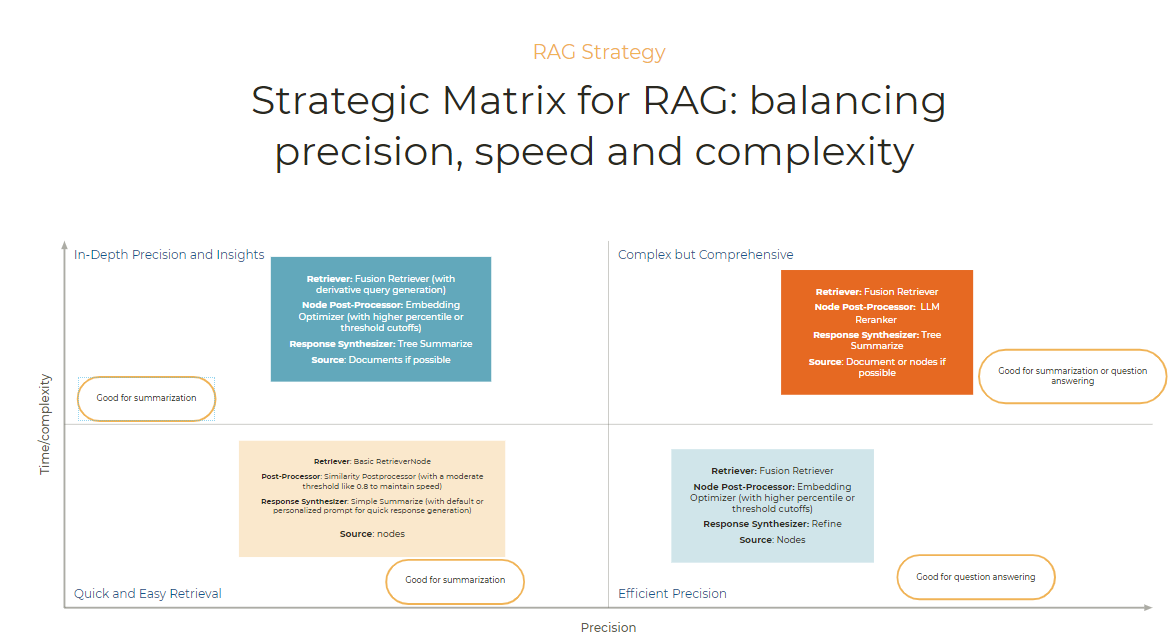

- Bottom Left (Quick and Straightforward Retrieval):
   - Strategy: Basic Retriever, Similarity Postprocessor (threshold: 0.8), Simple Response Synthesizer
   - Explanation: This approach is designed for rapid retrieval with low computational overhead. It quickly identifies relevant nodes and produces straightforward responses without intricate processing.
- Top Right (Comprehensive and Meticulous Analysis):
   - Strategy: Fusion Retriever, LLM Reranker, Tree Summarizer
   - Explanation: This setup prioritizes comprehensive analysis and depth of information. It integrates diverse retrieval methods, scrutinizes the relevance of content with an LLM, and constructs a well-structured and detailed response through a hierarchical summarization process.
- Bottom Right (Efficient Precision):
   - Strategy: Fusion Retriever, Embedding Optimizer, Refine Response Synthesizer
   - Explanation: Focused on delivering precise and contextually relevant results efficiently, this strategy combines the strengths of fusion retrieval and sentence-level optimization, and further refines the responses for clarity and relevance.
- Top Left (In-Depth Precision and Insights):
   - Strategy: Fusion Retriever, Embedding Optimizer, Tree Summarizer
   - Explanation: This approach offers meticulous precision and in-depth insights, suitable for complex queries requiring comprehensive analysis. It leverages the fusion retriever for a broad search scope, refines at a sentence level for precision, and employs a tree summarizer to weave a detailed and coherent narrative from multiple sources.

# Metadata search

Metadata plays a pivotal role in the process of identifying the most relevant nodes of information. However, there are instances where we already possess insights into the potential location of a response, achieved through a practice known as metadata filtering.

In our example, we have three distinct metadata categories that serve as valuable filters:

- Industry
- Business Interest
- Business Community

These metadata values, which were generated earlier in this notebook, are essentially keywords that enable us to refine our search.

## Basic search metadata

However, it's important to be aware of certain limitations within Llama Index:

1. **Date Filtering:** Llama Index does not offer support for date filtering. This means that users cannot filter information based on specific dates or time ranges, which may be essential for certain applications.

2. **Single Value Per Key:** Llama Index restricts the usage of only one value per key when filtering metadata. This limitation can be a constraint in scenarios where multiple values per key are required for more nuanced and complex filtering operations.


Source codes:
- https://docs.llamaindex.ai/en/stable/api/llama_index.vector_stores.MetadataFilter.html
- https://docs.llamaindex.ai/en/stable/api/llama_index.vector_stores.FilterOperator.html

In [ ]:
from llama_index.vector_stores.types import MetadataFilters,MetadataFilter, ExactMatchFilter, FilterCondition, FilterOperator

In [ ]:
df.head(1)
#clean_interest,clean_industry

We can see the most representated industries, business interest and business communities in our dataset.

In [ ]:
(
    df
    .explode("clean_industry")['clean_industry']
    .value_counts()
)

In [ ]:
(
    df
    .explode("clean_interest")['clean_interest']
    .value_counts()
)

In [ ]:
(
    df
    .explode("clean_communities")['clean_communities']
    .value_counts()
)

Let's filter the industry "Technology", and see how is the result

In [ ]:
filters = MetadataFilters(
    filters=[
        MetadataFilter(
        key="industry",
        value="Technology",
        operator=FilterOperator.EQ
        )
    ],
)

query_engine = index_with_splitter.as_query_engine(filters=filters)
response = query_engine.query(question)
response.response

In [ ]:
[response.source_nodes[i].metadata['industry'] for i in range(len(response.source_nodes))]

Additionally, it is feasible to apply filters to multiple metadata categories simultaneously. To achieve this, we utilize the 'MetadataFilter' multiple times. Users have the flexibility to opt for either an `AND` condition, which combines the two values, or an `OR` condition, which filters nodes based on the presence of either of the keywords.

In [ ]:
filters = MetadataFilters(
    filters=[
        MetadataFilter(
            key="industry",
            value="Technology",
            operator=FilterOperator.EQ
        ),
        MetadataFilter(
            key="interest",
            value="Consumer Goods",
            operator=FilterOperator.EQ
        )
    ],
    condition=FilterCondition.AND
)

In [ ]:
query_engine = index_with_splitter.as_query_engine(filters=filters,similarity_top_k=12)
response = query_engine.query(question)
response.response

In [ ]:
[response.source_nodes[i].metadata['industry'] for i in range(len(response.source_nodes))]

In [ ]:
[response.source_nodes[i].metadata['interest'] for i in range(len(response.source_nodes))]

## Multivalues search

In [ ]:
from itertools import product


def retrieve_nodes_for_multiple_filters(filter_dict, mode='full'):
    # Initialize an empty list to hold all retrieved nodes
    all_nodes = []
    seen_node_ids = set()

    if mode == 'or':
        # Original logic: Retrieve nodes for each key-value pair separately
        for key, values in filter_dict.items():
            for value in values:
                filters = MetadataFilters(
                    filters=[
                        ExactMatchFilter(key=key, value=value)
                    ]
                )
                query_engine = index_with_splitter.as_query_engine(filters=filters, similarity_top_k=10000)
                #### Strategy full
                nodes = query_engine.retrieve("full")
                list_ids = [node.id_ for node in nodes]
                list_nodes = index_with_splitter.docstore.get_nodes(node_ids=list_ids)
                all_nodes.extend(list_nodes)

    elif mode == 'and':
        # 'AND' logic: Retrieve nodes that match all key-value pairs simultaneously
        # Generate all combinations of key-value pairs
        all_combinations = list(product(*filter_dict.values()))

        for combination in all_combinations:
            filters = MetadataFilters(
                filters=[
                    MetadataFilter(key=key, value=value, operator=FilterOperator.EQ)
                    for key, value in zip(filter_dict.keys(), combination)
                ],
                condition=FilterCondition.AND
            )
            query_engine = index_with_splitter.as_query_engine(filters=filters, similarity_top_k=10000)
            #### Strategy full
            nodes = query_engine.retrieve("full")
            list_ids = [node.id_ for node in nodes]
            list_nodes = index_with_splitter.docstore.get_nodes(node_ids=list_ids)
            all_nodes.extend(list_nodes)

    else:
        raise ValueError("Invalid mode. Use 'or' or 'and'.")

    # Before returning all_nodes, filter out duplicates
    unique_nodes = [node for node in all_nodes if node.id_ not in seen_node_ids and not seen_node_ids.add(node.id_)]

    ## generate the vectorStore
    service_context_with_splitter_1 = ServiceContext.from_defaults(
            embed_model=embed_model,
            llm=llm,
          #text_splitter=text_splitter
        )
    vector_store_temp = VectorStoreIndex(unique_nodes,service_context=service_context_with_splitter_1)

    return unique_nodes, vector_store_temp



In [ ]:
(
    df
    .explode("clean_industry")['clean_industry']
    .value_counts()
    .head(2)
)

In [ ]:
(
    df
    .explode("clean_communities")['clean_communities']
    .value_counts()
    .head(2)
)

In [ ]:
(
    df
    .explode("clean_communities")
    .loc[lambda x: x['clean_communities'].isin(['ESIL - Early Stage Investing Launchpad'])][['formatted_card']]

)

In [ ]:
filter_dict = {
    'communities': ['ESIL - Early Stage Investing Launchpad'],
    'industry': ['Technology'],
}

In [ ]:
vi_nodes_or,vs_nodes_or = retrieve_nodes_for_multiple_filters(filter_dict, mode='or')
len(vs_nodes_or.docstore.docs)

In [ ]:
vi_nodes_or,vs_nodes_or = retrieve_nodes_for_multiple_filters(filter_dict, mode='and')
len(vs_nodes_or.docstore.docs)

In [ ]:
query = "What is the lowest ticket for the investor in the ESIL - Early Stage Investing Launchpad business community in Technology?"

In [ ]:
### No need to split again
service_context_with_splitter_1 = ServiceContext.from_defaults(
        embed_model=embed_model,
        llm=llm,
       #text_splitter=text_splitter
    )

In [ ]:
#### perform the search
retriever_base = vs_nodes_or.as_retriever(similarity_top_k=5)
query_engine = RetrieverQueryEngine.from_args(
     retriever_base,
    service_context=service_context_with_splitter_1,
     #text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    )
response = query_engine.query(query)
print(response.response)

## Search in document

In [ ]:
from llama_index.response_synthesizers import get_response_synthesizer

In [ ]:
from llama_index.schema import  NodeWithScore
def flatten_comprehension(matrix, remove_dup = True):
    if remove_dup:
        return list(set([item for row in matrix for item in row]))
    else:
        return [item for row in matrix for item in row]


In [ ]:
retriever_base = vs_nodes_or.as_retriever(similarity_top_k=10)
query_engine = RetrieverQueryEngine.from_args(
     retriever_base,
    service_context=service_context_with_splitter_1,
     #text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    )

In [ ]:
query = "XX"

In [ ]:
nodes_candidates = query_engine.retrieve(query)

In [ ]:
len(nodes_candidates)

In [ ]:
from statistics import mean
def reconstruct_document(node_with_answer, nodes_candidates):
    ### Node response
    node_response = node_with_answer.node.id_
    nodes_candidates_ids =  [i.node.id_ for i in nodes_candidates]
    ### node score
    #node_score = node_with_answer.score
    #### List best candidates
    node_parent = [values.node_id for key, values in node_with_answer.node.relationships.items() if key.value == '1'][0]
    doc_ids = index_with_splitter.docstore.get_ref_doc_info(ref_doc_id = node_parent)
    list_nodes = index_with_splitter.docstore.get_nodes(node_ids  = doc_ids.node_ids)
    list_nodes_ids = [i.id_ for i in list_nodes]
    #print(nodes_candidates, node_response)
    other_candidates = [i for i in list_nodes_ids if (i in nodes_candidates_ids) & (i != node_response)]
    append_score = [node_with_answer.score]
    append_nodes_score = [node_with_answer]
    append_nodes_text = [node_with_answer.node.text]
    append_candidates_ids = [node_response]
    for other_candidate in other_candidates:
        r_other_candidate = [i for i in nodes_candidates if i.node.id_ == other_candidate][0]
        append_score.append(r_other_candidate.score)
        append_nodes_score.append(r_other_candidate)
        append_nodes_text.append(r_other_candidate.text)
        append_candidates_ids.append(r_other_candidate.id_)

    #### List all nodes to use the document
    append_document_score: List[NodeWithScore] = []
    for i, node in enumerate(list_nodes):
        append_document_score.append(NodeWithScore(node=node, score=mean(append_score)))

    dic = {
        'parent':node_parent,
        'title':node_with_answer.node.metadata['title'],
        'node_best_choice':node_response,
        'node_best_choice_text':append_nodes_text,
        'list_scores':append_score,
        'nodes':doc_ids,
        "list_nodes_ids":list_nodes_ids,
        "list_nodes_candidates_ids":append_candidates_ids,
        'list_nodes':list_nodes,
        "NodeWithScore": append_nodes_score,
        "NodeWithScoreDocuments":append_document_score
    }

    return dic

def remove_duplicate_parents(list_of_dicts, key):
    unique_dicts = []
    seen_parents = set()

    for d in list_of_dicts:
        parent_value = d.get(key)  # Get the 'parent' value from the dictionary

        # Check if the 'parent' value is not in the set of seen parents
        if parent_value not in seen_parents:
            unique_dicts.append(d)  # Add the dictionary to the unique list
            seen_parents.add(parent_value)  # Add the 'parent' value to the set of seen parents

    return unique_dicts


In [ ]:
test = reconstruct_document(nodes_candidates[1],nodes_candidates)

In [ ]:
test['NodeWithScore']

In [ ]:
len(test['NodeWithScore'])

In [ ]:
### Extract all documents
all_docs = [reconstruct_document(node_with_answer = i,nodes_candidates = nodes_candidates) for i in nodes_candidates]
all_docs_removed_dup = remove_duplicate_parents(all_docs, 'parent')

In [ ]:
len(all_docs)

In [ ]:
[i['title'] for i in all_docs]

In [ ]:
len(all_docs_removed_dup)

In [ ]:
[i['title'] for i in all_docs_removed_dup]

In [ ]:
[print(i.text) for i in all_docs_removed_dup[1]['list_nodes']]

Select document or nodes

In [ ]:
list_full_nodes_responce = flatten_comprehension([i['NodeWithScore'] for i in all_docs_removed_dup], remove_dup = False)

### Test

In [ ]:
len(list_full_nodes_responce)

In [ ]:
retriever_base = index_with_splitter.as_retriever(similarity_top_k=30)

### filter nodes with lower score
sentence_embedding_postprocessor = SentenceEmbeddingOptimizer(
    embed_model=service_context_with_splitter.embed_model,
    percentile_cutoff=0.92,
    #threshold_cutoff=0.86
)

### Step 3: Define how to process the retriver an the answer
query_engine = RetrieverQueryEngine.from_args(
    retriever_base,
    service_context=service_context_with_splitter,
    node_postprocessors=[sentence_embedding_postprocessor],
    # response synthesizer args
    response_mode =  ResponseMode.SIMPLE_SUMMARIZE,
    text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    response_synthesizer = None
    )

### Step 4: Get the answer
print(question)
response = query_engine.query(question)
print(response)

In [ ]:
DEFAULT_REFINE_PROMPT = """
The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer
(only if needed) with some more context below
------------
{context_msg}
------------
Given the new context, refine the original answer to better
answer the query.
If the context isn't useful, return the original answer
Refined Answer:
"""

In [ ]:
from llama_index.prompts import SelectorPromptTemplate

In [ ]:
def get_refine_synthesizer(prompt):
    DEFAULT_REFINE_PROMPT_TMPL = PromptTemplate(
    prompt, prompt_type=PromptType.REFINE
)
    DEFAULT_REFINE_PROMPT_SEL = SelectorPromptTemplate(
    default_template=DEFAULT_REFINE_PROMPT_TMPL
)
    return DEFAULT_REFINE_PROMPT_SEL

In [ ]:
# Function to get the SentenceEmbeddingOptimizer
def get_sentence_embedding_optimizer(percentile_cutoff):
    return SentenceEmbeddingOptimizer(
        embed_model=service_context_with_splitter.embed_model,
        percentile_cutoff=percentile_cutoff
    )


In [ ]:
# service_context_with_splitter
retriever = index_with_splitter.as_retriever(similarity_top_k=10)

In [ ]:
postprocessor = get_sentence_embedding_optimizer(.8)

In [ ]:
query_engine = RetrieverQueryEngine.from_args(
                retriever,
                service_context=service_context_with_splitter,
                node_postprocessors=[postprocessor],
                response_mode=ResponseMode.SIMPLE_SUMMARIZE,
    #text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
    #response_synthesizer = None
            )

In [ ]:
from llama_index.schema import NodeWithScore, QueryBundle

In [ ]:
results = query_engine.retrieve(QueryBundle(question))

In [ ]:
## We generate the answers on all the nodes within the collection
_response_synthesizer = get_response_synthesizer(
            service_context=service_context_with_splitter_1,
            callback_manager=None,
            response_mode = ResponseMode.REFINE,
    refine_template = get_refine_synthesizer(DEFAULT_REFINE_PROMPT)
            #text_qa_template = DEFAULT_TEXT_QA_PROMPT1,
        )
response = _response_synthesizer.synthesize(
    query=query,
    nodes=list_full_nodes_responce
)
[print(i, '\n') for i in response.response.split('.')]